# Natural Language Processing - Consumer Complaint in bank sector

## Research question: 

* How to develop an automatic text classification model that assigns customer complaints to the correct product categories based on their content?

Authors: Alam Jasia, Hubweber Michaela, Schumich Kathrin, Ye Florian

Dataset: https://www.kaggle.com/datasets/shashwatwork/consume-complaints-dataset-fo-nlp

In [1]:
import os
import re
# Ignore warnings
import warnings
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from gensim.models import KeyedVectors, Word2Vec
from IPython.display import display
from scipy import stats
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder  # For encoding labels

from sklearn.model_selection import train_test_split
from spacy.cli import download
from textblob import TextBlob
from wordcloud import WordCloud

from narrative_to_vec import add_column_average_genre_vector, tokenize_column
from narrative_to_vec import tokenize_column, add_column_average_genre_vector, train_word2vec_model, store_data

warnings.filterwarnings('ignore')

/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


## 4 Testing different embedding techniques

***Goal: Try out different embeddings to see, how (or if) the product categories can be clustered by cosine similarity.***

In [2]:
# load small data from notebook 2
data_path = os.path.join("data", "small_data_eda.zip")
data = pd.read_csv(data_path)
data.head()

,product,narrative,narrative_len,narrative_prep,narrative_prep_len,text_lemma,word_count,char_count,sentence_count,sentiment
0,credit_card,used third party company book vacation package...,64,party company book vacation package notified c...,53,party company book vacation package notify com...,64,485,1,-0.138095
1,credit_card,company u bank reliacard issue account locked ...,66,company u bank reliacard issue account locked ...,58,company u bank reliacard issue account locked ...,66,421,1,-0.083333
2,credit_card,victim identity fraud personal financial infor...,91,victim identity fraud personal financial infor...,83,victim identity fraud personal financial infor...,91,696,1,-0.002679
3,credit_card,browsing online site invited apply credit card...,70,browsing online site invited apply credit card...,64,browse online site invite apply credit card si...,70,496,1,-0.243056
4,credit_card,made payment credit card balance resulting cre...,20,payment credit card balance resulting credit b...,18,payment credit card balance result credit bala...,20,143,1,0.000000


### Label Encoding

In [3]:
# numerical encoding of product categories
le = LabelEncoder()
y = le.fit_transform(data['product'])  # Transform product categories into numerical labels
y

array([0, 0, 0, ..., 4, 4, 4])

In [4]:
# function to get and plot cosine similiraty by product category
def plot_cosine_similarity(embeddings, name):
    cosine_sim = cosine_similarity(embeddings)
    # plot the cosine similarity matrix as a heatmap
    sns.heatmap(cosine_sim, annot=True, cmap='coolwarm',
                xticklabels=embeddings.index,
                yticklabels=embeddings.index
                ).set_title("Cosine Similarity Matrix for " + name)  

#### 4.1 TFIDF on lemmatized text
* Updated TFIDF (inclusive Feedback Presentation 1)

In [5]:
# create TF-IDF vectorizer and fit it on the complaints
vectorizer = TfidfVectorizer(max_features=150, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['text_lemma'])
# convert to a dataframe for easier manipulation
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [6]:
# add the categories back to the dataframe
tfidf_df['product'] = data['product'].values
# group by category and calculate their average tfidf values
category_embeddings = tfidf_df.groupby('product').mean()

In [7]:
# save embeddings
tfidf_df.to_pickle(os.path.join("data", "tfidf_embeddings.pkl"))

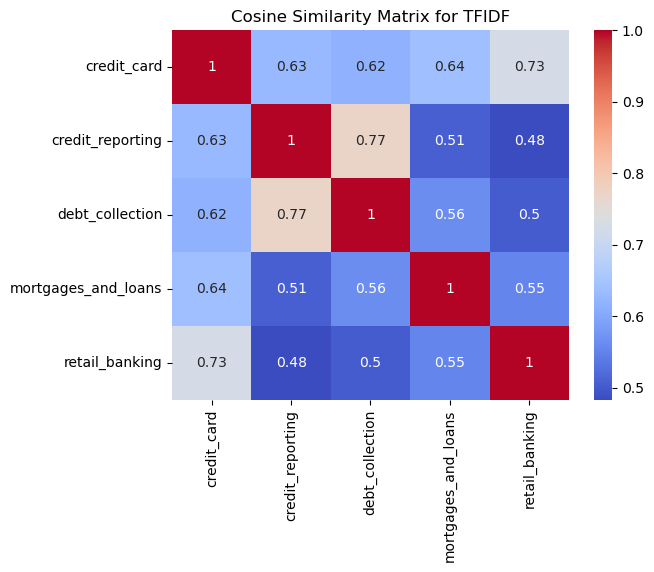

In [8]:
plot_cosine_similarity(category_embeddings, "TFIDF")

#### 4.2 GLOVE on lemmatized text

The used model glove.6B.100d.txt is too large to push to github, but can be downloaded from https://nlp.stanford.edu/projects/glove/ and should be placed in the data folder.

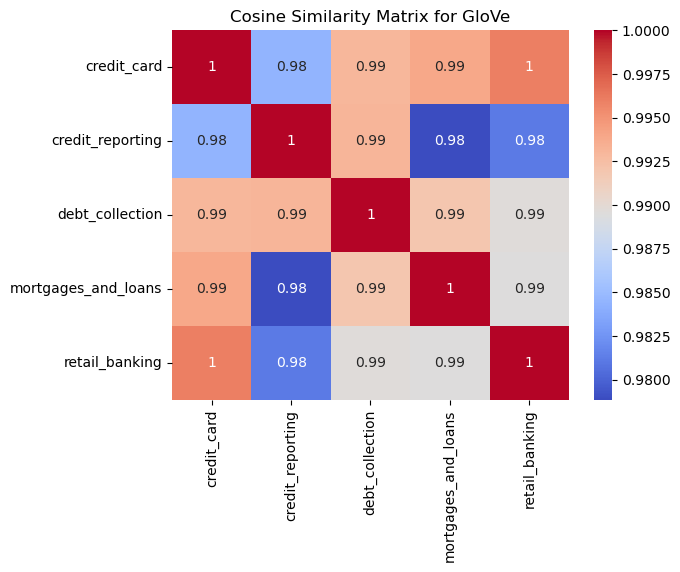

In [9]:
# load the model
def load_glove_model():
    zip_path = os.path.join("data", "glove.6B.100d.zip")
    glove_file = os.path.join("data", "glove.6B.100d.txt")

    #unzip the file if not already unzipped
    if not os.path.exists(glove_file):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("data")

    # create dict from glove file  
    glove_model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove_model[word] = vector
    return glove_model

# get the average GloVe embedding for a complaint
def get_average_embedding(text, glove_model):
    # split the text into words
    words = text.split()

    # get embeddings for each word
    embeddings = []
    for word in words:
        if word in glove_model:
            embeddings.append(glove_model[word])
    # return average if embeddings are found or zeros otherwise
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(100)

# load model and get embeddings
glove_model = load_glove_model()

# create a dataframe with the average embeddings for each complaint
glove_df = data['text_lemma'].apply(lambda x: get_average_embedding(x, glove_model)).to_frame()
# add the categories back to the dataframe
glove_df['product'] = data['product'].values
# save the embeddings as a pickle file
glove_df.to_pickle(os.path.join("data", "glove_embeddings.pkl"))

# group by category and calculate their average embeddings
glove_df = glove_df.groupby('product')['text_lemma'].apply(np.mean)
glove_df = pd.DataFrame(glove_df.tolist(), index=glove_df.index)

plot_cosine_similarity(glove_df, "GloVe")


#### 4.3 Sentence transformers on unlemmatized text:

In [10]:
# get small BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')
sbert = model.encode(data["narrative_prep"])

In [11]:
# convert to a dataframe and add the categories back
sbert_df = pd.DataFrame(sbert)
sbert_df['product'] = data['product'].values

In [12]:
# save as a pickle file
sbert_df.to_pickle(os.path.join("data", "sbert_embeddings.pkl"))

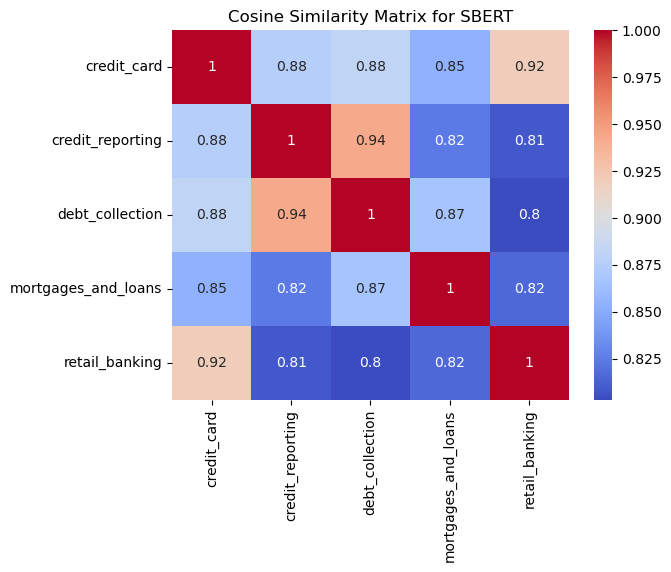

In [13]:
sbert_df = sbert_df.groupby('product').mean()
plot_cosine_similarity(sbert_df, "SBERT")

#### 4.4 Word-to-Vec

In [14]:
col_name = "narrative_tokenized"

# tokenize the columns
data_w2v = tokenize_column(data, "narrative_prep", col_name)

# train w2v model on the tokenized column
train_word2vec_model(data, col_name=col_name)

# add new column with the average genre vector
data_w2v = add_column_average_genre_vector(data, 
                                        model_path="narrative_word2vec.model", 
                                        col_name=col_name)

# store the data as a pickle file
#store_data(data_w2v, os.path.join("data", "word2vec_embeddings.pkl"))
data_w2v.to_pickle(os.path.join("data", "word2vec_embeddings.pkl"))

print("Done!")


Done!


In [15]:
data_w2v_df = data_w2v.groupby('product')['narrative_tokenized_vector'].apply(np.mean)
data_w2v_df = pd.DataFrame(data_w2v_df.tolist(), index=data_w2v_df.index)
data_w2v_df

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
product,,,,,,,,,,,,,,,,,,,,,
credit_card,-0.126781,0.364356,0.120213,0.010691,0.058150,0.344435,0.298767,-0.243169,-0.078459,-0.030224,...,-0.232974,-0.165890,-0.067306,0.269567,-0.425688,0.039325,0.210247,-0.275891,-0.423077,0.574330
credit_reporting,-0.529744,0.209598,0.026636,0.273409,-0.194175,0.431887,0.419494,0.034799,-0.069664,0.089190,...,0.058838,-0.403469,0.041491,-0.192297,-0.218029,-0.098438,-0.129519,-0.076574,-0.223240,0.259354
debt_collection,-0.384455,0.496386,0.063380,-0.037752,-0.075065,0.435546,0.465154,-0.057556,-0.234233,-0.085587,...,-0.009928,-0.254663,0.006531,-0.148088,-0.207727,-0.320493,0.008880,0.039016,-0.374528,0.370372
mortgages_and_loans,0.051741,0.340996,0.033627,-0.021505,-0.084284,0.213250,0.353190,-0.323314,-0.272501,-0.084247,...,-0.302373,-0.064646,-0.107105,0.375665,-0.278351,-0.154598,0.055002,-0.348915,-0.348596,0.657639
retail_banking,-0.233272,0.393208,0.289621,0.228356,0.182353,0.270318,0.089318,-0.320738,-0.003773,-0.117356,...,-0.239550,0.068053,-0.351521,0.158733,-0.549606,0.125599,0.315552,-0.325526,-0.530085,0.568179


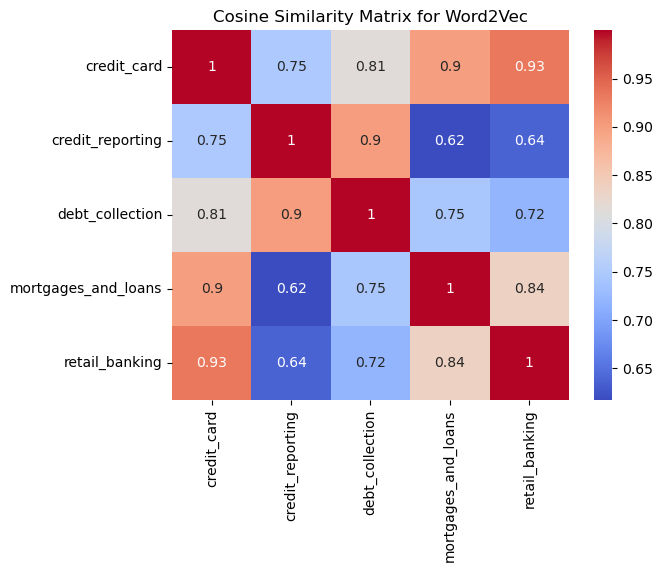

In [16]:
similarity_matrix = cosine_similarity(data_w2v_df)
plot_cosine_similarity(data_w2v_df, "Word2Vec")